# Object Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import models, layers, utils
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt

import numpy as np

In [3]:
img_size = (299, 299, 3)
img_dir = "../subset_stanford_online_products"
batch_size = 32
lr = 1e-4
epoch = 22

## Prepare Dataset

In [4]:
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest',
                                         validation_split=0.2)

# Note that the validation data should not be augmented!
test_datagen = image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    img_dir,
    subset="training",
    # All images will be resized to 299 x 299
    target_size=img_size[:2],
    batch_size=batch_size,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode='categorical',
    shuffle=True,
    seed=1234)

validation_generator = test_datagen.flow_from_directory(
    img_dir,
    subset="validation",
    target_size=img_size[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=1234)

Found 9600 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


### Cek Training Dataset

In [6]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [7]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

10

In [8]:
fname = train_generator.filenames[image_idx]
fname

'table_final/301420675267_2.JPG'

In [9]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

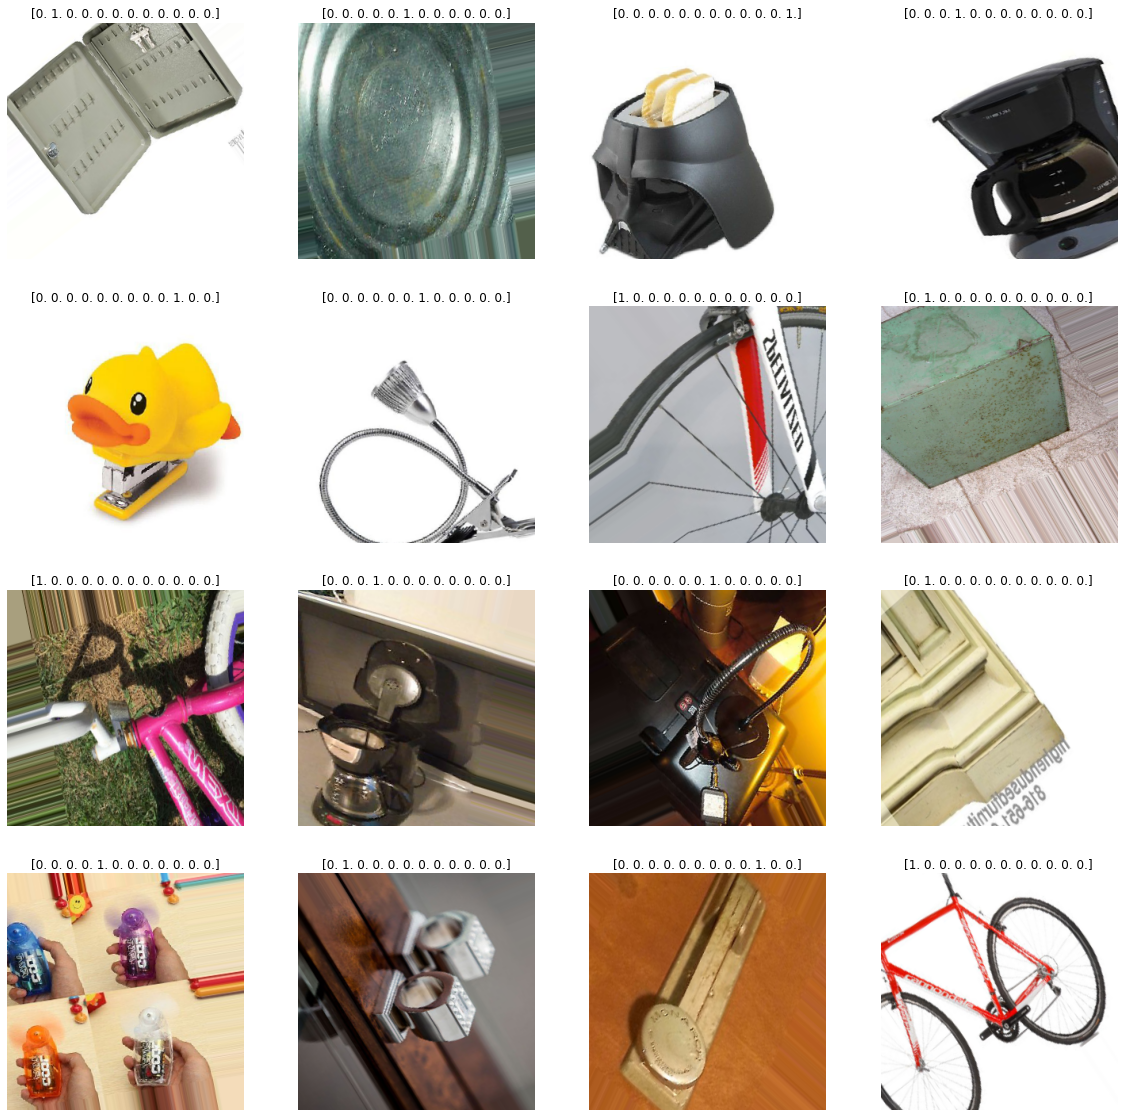

In [10]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

### Cek Validation Dataset

In [11]:
validation_generator[0][0].shape

(32, 299, 299, 3)

In [12]:
image_idx = validation_generator.index_array[1]
validation_generator.labels[image_idx]

1

In [13]:
fname = validation_generator.filenames[image_idx]
fname

'cabinet_final/141622830935_2.JPG'

In [14]:
validation_images_7, validation_labels_7 = validation_generator[7]
print(validation_images_7.shape)
print(validation_labels_7.shape)

(32, 299, 299, 3)
(32, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

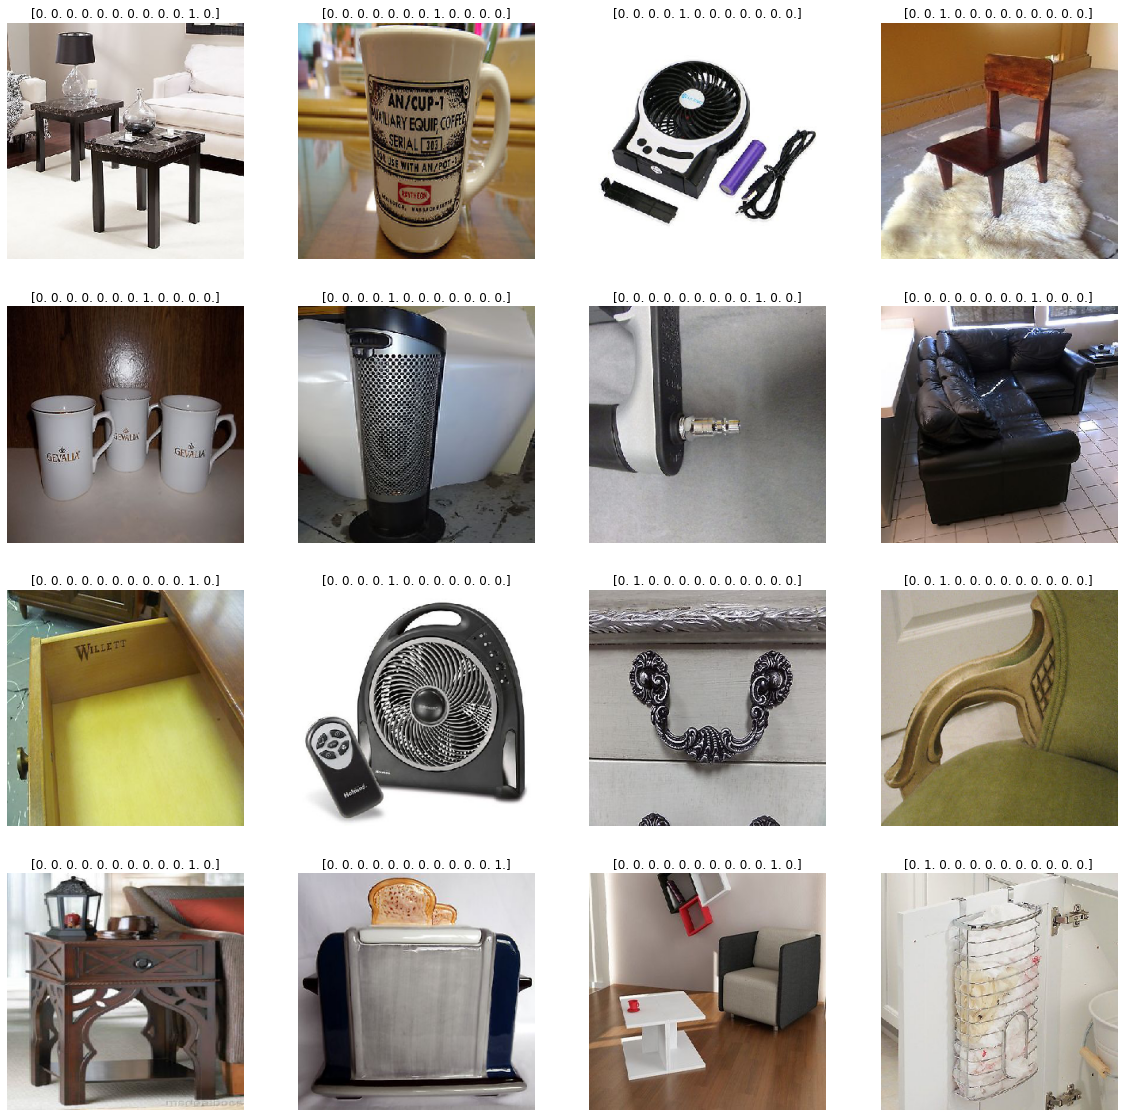

In [15]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(validation_images_7[idx]))
    plt.title(str(validation_labels_7[idx]))
    plt.axis('off')

plt.show

## Define Model with multi GPU

In [16]:
def create_model():
    conv_base = Xception(weights=None, include_top=False, input_shape=img_size)

    conv_base.trainable = True

    input_layer = keras.Input(shape=img_size)
    x = conv_base(input_layer)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [17]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [18]:
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr),
                  metrics=[metrics.CategoricalAccuracy()])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           xception[1][0]                   
______________________________________________________________________________________________

<font color='red'> Jumlah parameter yang di-training hanya 21jtan </font>

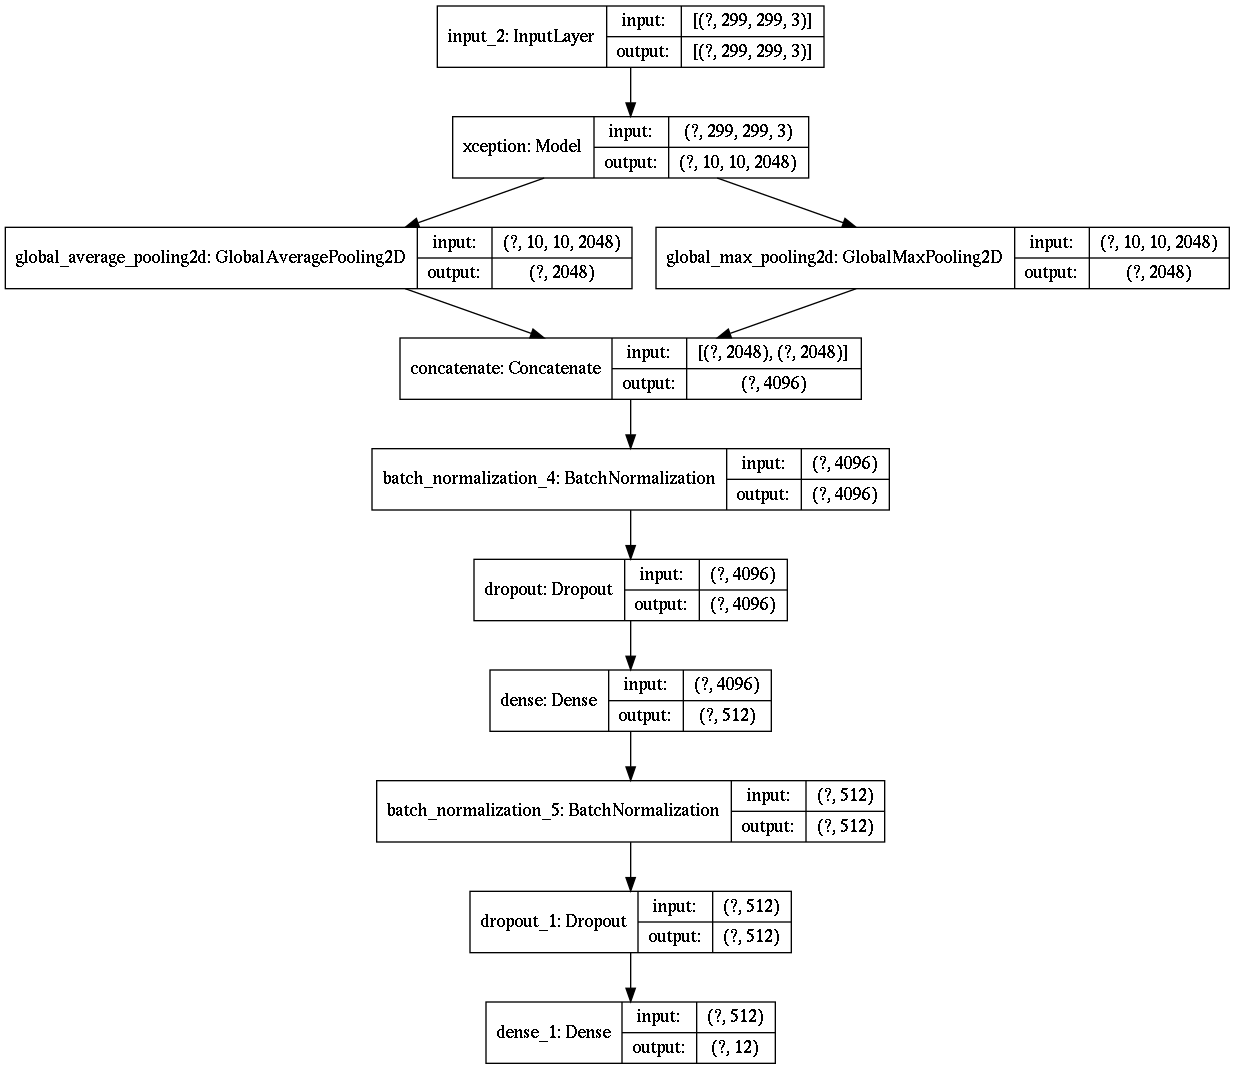

In [20]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Training Model

In [21]:
history = model.fit(train_generator,
                    epochs=epoch,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 75 steps
Epoch 1/22
INFO:tensorflow:batch_all_reduce: 162 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 162 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
300/300 [==============================] - 200s 667ms/step - loss: 3.3059 - categorical_accuracy: 0.1390 - val_loss: 3.2693 - val_categorical_accuracy: 0.0833
Epoch 2/22
300/300 [==============================] - 185s 615ms/step - loss: 3.0144 - categorical_accuracy: 0.1552 - val_loss: 2.6651 - val_categorical_accuracy: 0.1063
Epoch 3/22
300/300 [==============================] - 185s 617ms/step - loss: 2.8754 - categorical_accuracy: 0.1685 - val_loss: 2.4362 - val_categorical_accuracy: 0.2317
Epoch 4/22
300/300 [==============================] - 184s 614ms/step - loss: 2.8022 - cate

In [22]:
model.metrics_names

['loss', 'categorical_accuracy']

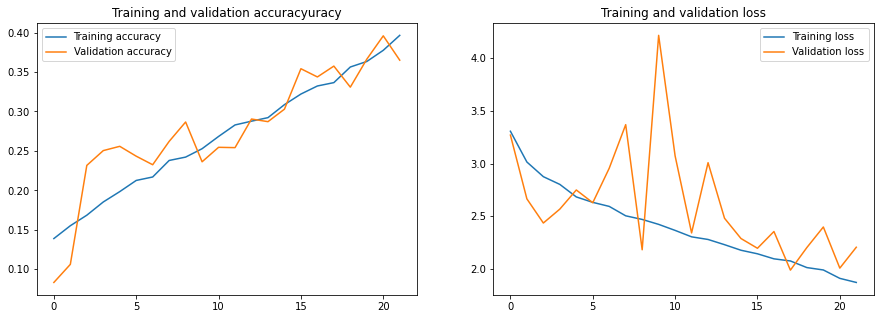

In [23]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate Model

In [24]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 11s 150ms/step - loss: 2.2066 - categorical_accuracy: 0.3650


[2.2065927012761435, 0.365]

In [25]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [26]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 11s 144ms/step


In [27]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.63      0.49      0.55       200
     cabinet       0.30      0.57      0.39       200
       chair       0.38      0.05      0.09       200
 coffe_maker       0.24      0.57      0.34       200
         fan       0.36      0.66      0.47       200
      kettle       0.36      0.29      0.33       200
        lamp       0.30      0.35      0.32       200
         mug       0.45      0.45      0.45       200
        sofa       0.60      0.31      0.41       200
     stapler       0.47      0.39      0.42       200
       table       0.42      0.11      0.17       200
     toaster       0.29      0.14      0.19       200

    accuracy                           0.36      2400
   macro avg       0.40      0.36      0.35      2400
weighted avg       0.40      0.36      0.35      2400



In [28]:
model.save("end_to_end_learning.h5")